# DPGP3 Exploratory analysis


The goal of this notebook is to plot descriptive statistics of the DPGP3 data

TO-DO:
1. Coverage by position (make sure that makes sense).
2. Fraction polymorphic and $\pi$ by position.
3. Select a "homogeneous" portion.
4. Allele frequency spectrum.
5. Choose a positional coarse-graining so that there is O(1) segregating site per window.
6. Plot coverage distribution in focal region. Choose a minimum coverage.
7. Choose several frequency coarse-grainings. Calculate the SFS cross-correlations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "/home/dpr/mmc_genomics/src")
import helpers as h

In [3]:
data_dir = '/project/jnovembre/data/external_public/DPGP3/'
chromosomes = ['Chr2L', 'Chr2R', 'Chr3L', 'Chr3R']
files = [data_dir + c + '.mac.txt.gz' for c in chromosomes]

In [4]:
chrom_lengths = [23011544, 21146708, 24543557, 27905053]

Begin by looking at a single chromosome arm: Chr2L

In [5]:
data = h.loadints(files[0], chrom_lengths[0], 2)

In [6]:
print(len(data))
print(data.size)

23011544
46023088


## Coverage distributions

We are going to want to coarse-grain the data for plotting purposes. We'll pick a window size and plot vs position.

In [7]:
w = 1000
n_w = data.shape[0] // w
pos = np.arange(n_w)*w

In [8]:
nobs = data[:n_w*w,0].reshape((n_w,w))

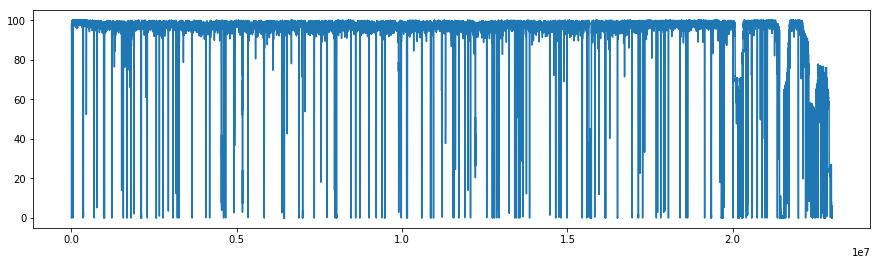

In [9]:
plt.figure(figsize=(15,4))
plt.plot(pos, np.mean(nobs,axis=1), linestyle='steps-pre')

Coverage does not depend strongly on position in a regular way. There are occasional windows of no coverage, which we'll want to screen out.

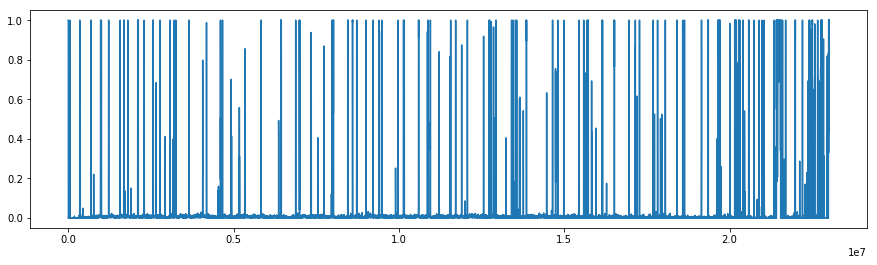

In [10]:
plt.figure(figsize=(15,4))
plt.plot(pos, np.mean(nobs==0,axis=1), linestyle='steps-pre')

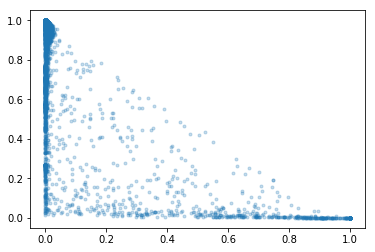

In [11]:
plt.plot(np.mean(nobs==0,axis=1), np.mean(nobs,axis=1)/100, '.', alpha=0.25)

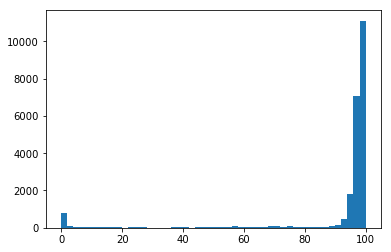

In [12]:
plt.hist(np.mean(nobs,axis=1), bins=np.arange(0,102,2));

# Diversity

In [13]:
n_poly = (data[:n_w*w,1]>0).reshape((n_w,w))
np.sum(n_poly)

1696687

In [14]:
f_poly = np.sum(n_poly, axis=1) / np.sum(nobs>0, axis=1)

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


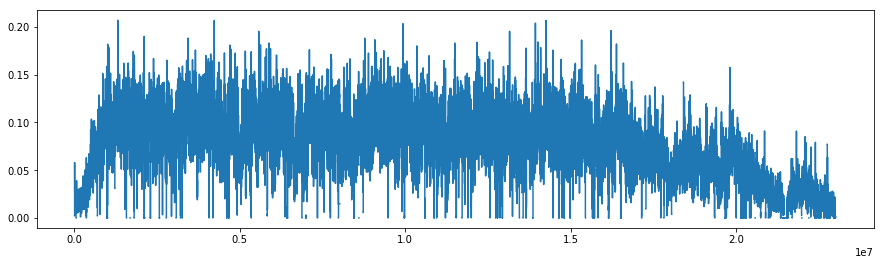

In [15]:
plt.figure(figsize=(15,4))
plt.plot(pos, f_poly, linestyle='steps-pre')

Low diversity near the telomere and centromere, roughly constant in the middle, but very variable at the 10KB scale.

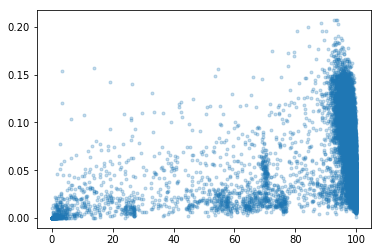

In [16]:
plt.plot(np.mean(nobs,axis=1), f_poly, '.', alpha=0.25)

(95, 100)

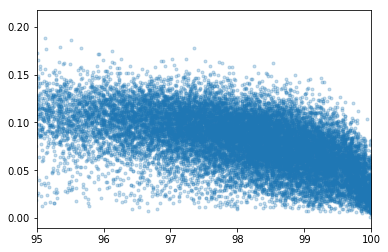

In [17]:
plt.plot(np.mean(nobs,axis=1), f_poly, '.', alpha=0.25)
plt.xlim([95,100])

Among high-coverage regions, more diversity is correlated with less coverage.

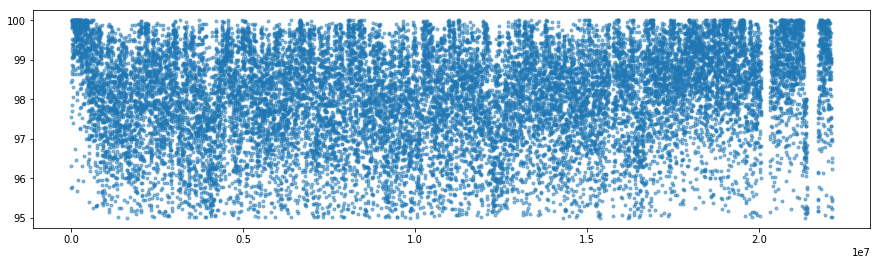

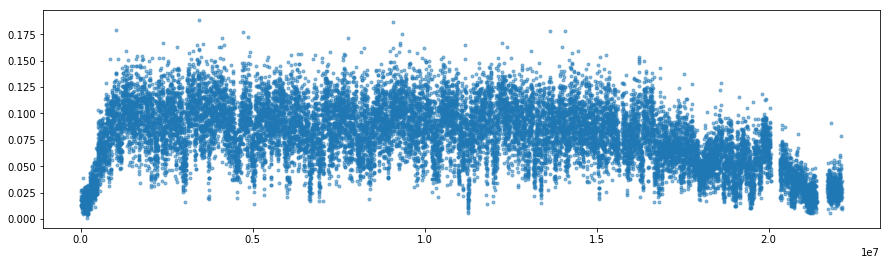

In [18]:
cov_filter = np.mean(nobs,axis=1) >= 95
plt.figure(figsize=(15,4))
plt.plot(pos[cov_filter],np.mean(nobs,axis=1)[cov_filter], '.', alpha=0.5)
plt.show()
plt.figure(figsize=(15,4))
plt.plot(pos[cov_filter], f_poly[cov_filter], '.', alpha=0.5)

Let's start the "middle" region at 1Mb and go to 15Mb.

In [19]:
start = 1000000 // w
end = 15000000 // w

(95, 100)

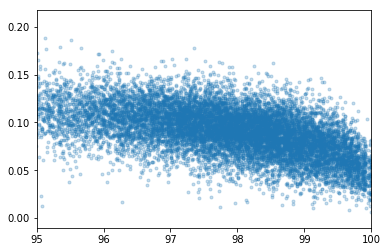

In [20]:
plt.plot(np.mean(nobs,axis=1)[start:end], f_poly[start:end], '.', alpha=0.25)
plt.xlim([95,100])

In [21]:
np.sum(data[:,0] > 95) / data.shape[0]

0.83628030348593729

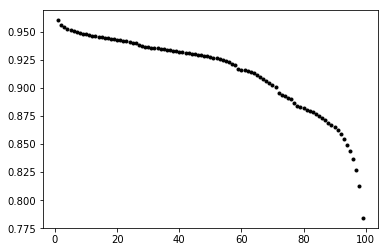

In [22]:
for i in range(1,100):
    plt.plot(i, np.sum(data[:,0] >= i) / data.shape[0], 'k.')

In [23]:
data_masked = np.copy(data)

In [24]:
nobs_cutoff = 80
data_masked[data[:,0] < nobs_cutoff, :] = 0

In [25]:
nobs = data_masked[:n_w*w,0].reshape((n_w,w))
n_poly = (data_masked[:n_w*w,1]>0).reshape((n_w,w))
np.sum(n_poly)
f_poly = np.sum(n_poly, axis=1) / np.sum(nobs>0, axis=1)

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


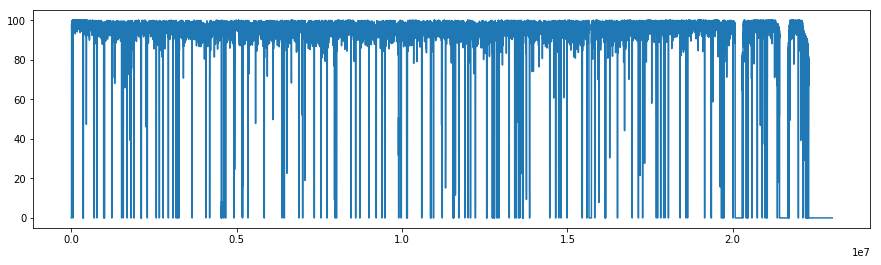

In [26]:
plt.figure(figsize=(15,4))
plt.plot(pos, np.mean(nobs,axis=1), linestyle='steps-pre')

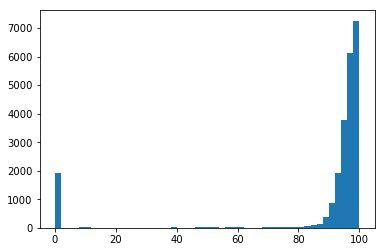

In [27]:
plt.hist(np.mean(nobs,axis=1), bins=np.arange(0,102,2));

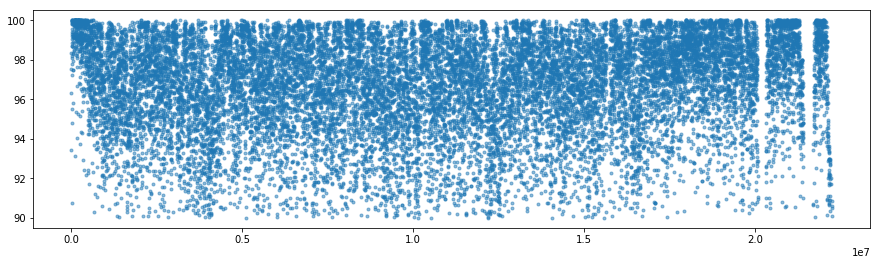

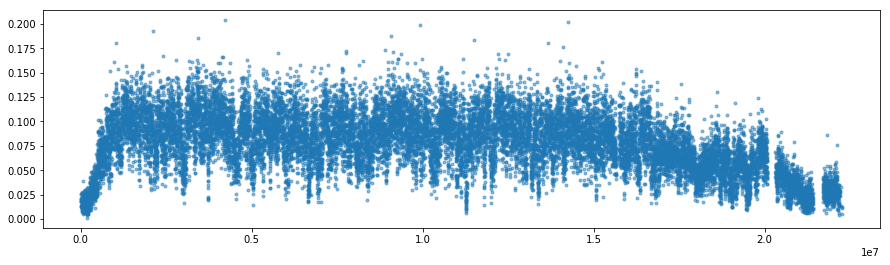

In [28]:
cov_filter = np.mean(nobs,axis=1) >= 90
plt.figure(figsize=(15,4))
plt.plot(pos[cov_filter],np.mean(nobs,axis=1)[cov_filter], '.', alpha=0.5)
plt.show()
plt.figure(figsize=(15,4))
plt.plot(pos[cov_filter], f_poly[cov_filter], '.', alpha=0.5)

# Choosing a window size for masking

We'd like to mask regions with poor coverage. We don't want to trust sites in regions with lots of missing data or masked sites, even if the sites themselves have good coverage. This involves chosing a spatial scale at which the coverage becomes uncorrelated.

In [29]:
start = int(1e6)
stop = int(15e6)
nobs = data[start:stop,0]

We're going to use the function np.correlate. First, let's test it out on a toy example to make sure we understand how it works.

In [30]:
v = np.arange(5)
a = np.arange(7)
print(np.correlate(a,v))

[30 40 50]


In [31]:
x = np.arange(7)
k_max = 2
print(np.correlate(x, x[:-2]))

[30 40 50]


In [32]:
x = np.arange(7)
k_max = 4
print(np.correlate(x, x[:-k_max]))

[ 5  8 11 14 17]


In [33]:
print(np.correlate(np.arange(10), np.ones(6)))

[ 15.  21.  27.  33.  39.]


In [34]:
print(np.correlate(np.arange(100), np.ones(6)))
print(np.correlate(np.arange(100)[50:], np.ones(6)))

[  15.   21.   27.   33.   39.   45.   51.   57.   63.   69.   75.   81.
   87.   93.   99.  105.  111.  117.  123.  129.  135.  141.  147.  153.
  159.  165.  171.  177.  183.  189.  195.  201.  207.  213.  219.  225.
  231.  237.  243.  249.  255.  261.  267.  273.  279.  285.  291.  297.
  303.  309.  315.  321.  327.  333.  339.  345.  351.  357.  363.  369.
  375.  381.  387.  393.  399.  405.  411.  417.  423.  429.  435.  441.
  447.  453.  459.  465.  471.  477.  483.  489.  495.  501.  507.  513.
  519.  525.  531.  537.  543.  549.  555.  561.  567.  573.  579.]
[ 315.  321.  327.  333.  339.  345.  351.  357.  363.  369.  375.  381.
  387.  393.  399.  405.  411.  417.  423.  429.  435.  441.  447.  453.
  459.  465.  471.  477.  483.  489.  495.  501.  507.  513.  519.  525.
  531.  537.  543.  549.  555.  561.  567.  573.  579.]


In [35]:
k_max = 10000
mean = np.mean(nobs)
cov = (np.correlate(nobs, nobs[:-k_max]) / (len(nobs)-k_max)) - mean**2

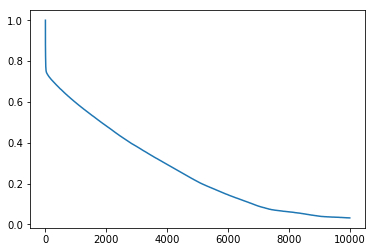

In [36]:
plt.plot(cov/cov[0])

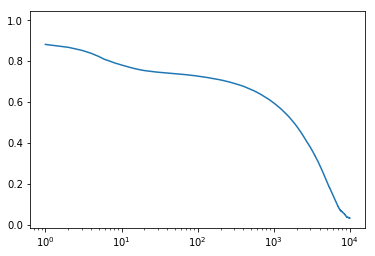

In [37]:
plt.semilogx(cov/cov[0])

(-0.1, 1.1)

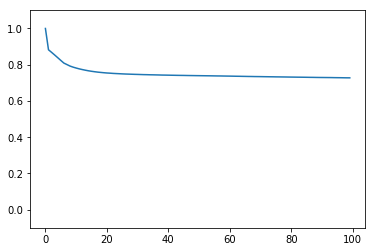

In [38]:
plt.plot(cov[:100]/cov[0])
plt.ylim([-0.1,1.1])

1001


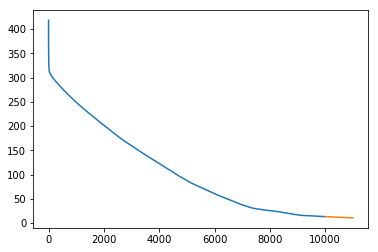

In [39]:
#print(k_max)
plt.plot(np.arange(k_max+1), cov)
k_max2 = 1000
gap = 10000
cov2 = np.correlate(nobs[gap:], nobs[:-gap-k_max2])
print(len(cov2))
plt.plot(gap+np.arange(k_max2+1), (cov2/(len(nobs)-gap) - mean**2))

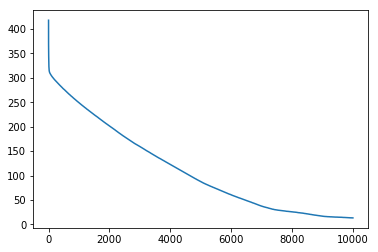

In [40]:
plt.plot(cov)

# Diversity correlations

First, ignore missing data.

In [41]:
poly = (data[start:stop,1] > 0).astype(int)
print(poly[10000:10200])

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [42]:
poly_mean = np.mean(poly)
print(poly_mean)

0.0888517142857


In [43]:
poly_mean**2

0.0078946271315102033

In [44]:
k_max = 1000
cov = (np.correlate(poly, poly[:-k_max]) / (len(poly)-k_max)) - poly_mean**2

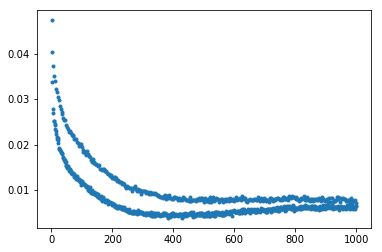

In [45]:
plt.plot(np.arange(1,k_max+1), cov[1:]/cov[0], '.')

(0, 0.05)

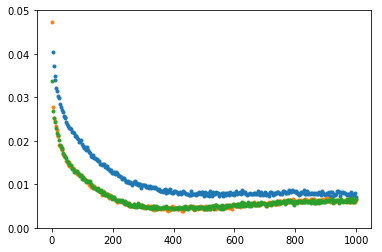

In [46]:
plt.plot(np.arange(k_max+1)[::3], cov[::3]/cov[0], '.')
plt.plot(np.arange(k_max+1)[1::3], cov[1::3]/cov[0], '.')
plt.plot(np.arange(k_max+1)[2::3], cov[2::3]/cov[0], '.')
plt.ylim([0,0.05])
#plt.xscale('log')
#plt.yscale('log')

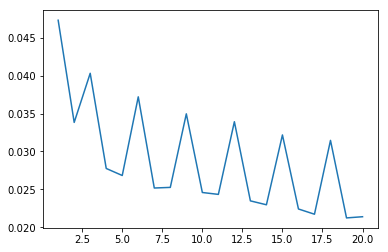

In [110]:
plt.plot(np.arange(1,21), cov[1:21]/cov[0])

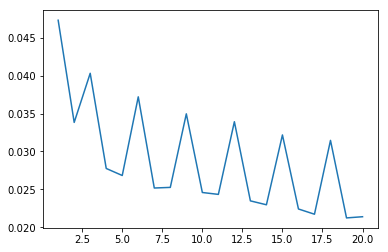

In [110]:
plt.plot(np.arange(1,21), cov[1:21]/cov[0])

In [90]:
x = np.random.randint(2, size=1000)
print(np.correlate(x, x[:-10]) / (1000-10))

[ 0.53333333  0.29292929  0.26262626  0.28181818  0.28383838  0.28585859
  0.28787879  0.29393939  0.27777778  0.28181818  0.27676768]


In [130]:
mac = data[start:stop,1]
pi = h.pairwise_diversity(mac, nobs)

/home/dpr/mmc_genomics/src/helpers.py:6: RuntimeWarning: invalid value encountered in true_divide
  f = allele_counts / sample_size
/home/dpr/mmc_genomics/src/helpers.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))
/home/dpr/mmc_genomics/src/helpers.py:7: RuntimeWarning: invalid value encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))


In [132]:
pi[np.isnan(pi)] = 0

In [137]:
k_max = 10000
cov = (np.correlate(pi, pi[:-k_max]) / (len(pi)-k_max)) - np.mean(pi)**2

(0, 0.05)

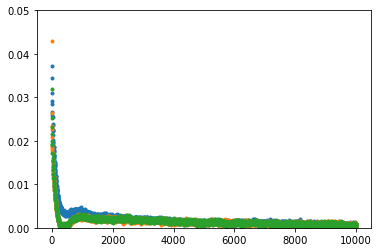

In [138]:
plt.plot(np.arange(k_max+1)[::3], cov[::3]/cov[0], '.')
plt.plot(np.arange(k_max+1)[1::3], cov[1::3]/cov[0], '.')
plt.plot(np.arange(k_max+1)[2::3], cov[2::3]/cov[0], '.')
plt.ylim([0,0.05])

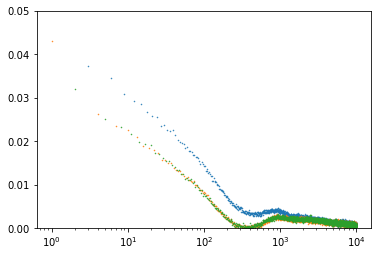

In [140]:
plt.plot(np.arange(k_max+1)[::3], cov[::3]/cov[0], '.', ms=1)
plt.plot(np.arange(k_max+1)[1::3], cov[1::3]/cov[0], '.', ms=1)
plt.plot(np.arange(k_max+1)[2::3], cov[2::3]/cov[0], '.', ms=1)
plt.ylim([0,0.05])
plt.xscale('log')

# SFS correlations

In [47]:
k_max = int(1e3)

In [48]:
start = int(1e6)
stop = int(15e6)
nobs = data[start:stop,0]
mac = data[start:stop,1]

In [49]:
maf = mac / nobs
maf[np.isnan(maf)] = 0

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [11]:
pi = h.pairwise_diversity(mac, nobs)
pi[np.isnan(pi)] = 0

/home/dpr/mmc_genomics/src/helpers.py:6: RuntimeWarning: invalid value encountered in true_divide
  f = allele_counts / sample_size
/home/dpr/mmc_genomics/src/helpers.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))
/home/dpr/mmc_genomics/src/helpers.py:7: RuntimeWarning: invalid value encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))


In [12]:
poly = (mac > 0).astype(int)

We need to deal with the no counts. That means adjusting the denominator by the number of comparisons with no counts.

In [13]:
has_cov = (nobs > 0).astype(int)

In [14]:
comparisons = np.correlate(has_cov, has_cov[:-k_max])

In [15]:
pi_corr = np.correlate(pi, pi[:-k_max])

In [16]:
pi_mean = np.sum(pi) / np.sum(has_cov)

In [17]:
pi_cov = pi_corr/comparisons - pi_mean**2

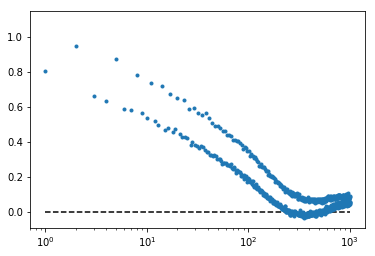

In [18]:
plt.semilogx(pi_cov[1:] / pi_mean**2, '.')
plt.hlines(0, 1, k_max, linestyle='dashed')

In [19]:
pi_corr2 = h.cross_correlation(pi, pi, k_max)

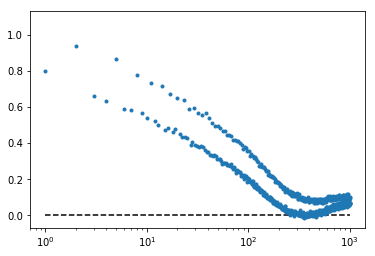

In [20]:
plt.semilogx(pi_corr2[1:]/pi_mean**2, '.')
plt.hlines(0, 1, k_max, linestyle='dashed')

In [22]:
poly_corr =  np.correlate(poly, poly[:-k_max])
poly_mean = np.sum(poly) / np.sum(has_cov)
poly_cov = poly_corr/comparisons - poly_mean**2

In [23]:
print(poly_mean)
print(pi_mean)

0.0914714971666
0.010806474246


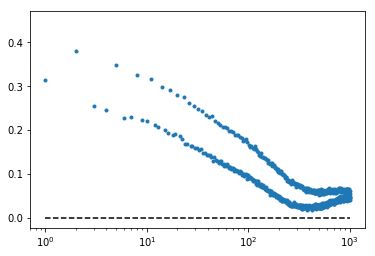

In [24]:
plt.semilogx(poly_cov[1:] / poly_mean**2, '.')
plt.hlines(0, 1, k_max, linestyle='dashed')

In [25]:
freq_cutoff = 0.05
hi_freq = ((mac>0) & (maf > freq_cutoff)).astype(int)
lo_freq = ((mac>0) & (maf <= freq_cutoff)).astype(int)

In [26]:
f_hi = np.sum(hi_freq) / np.sum(has_cov)
f_lo = np.sum(lo_freq) / np.sum(has_cov)
print(f_lo, f_hi, poly_mean)

0.0616699686169 0.0298015285497 0.0914714971666


In [27]:
hilo_corr = np.correlate(hi_freq, lo_freq[:-k_max])

In [28]:
hilo_cov = hilo_corr/comparisons - f_lo*f_hi

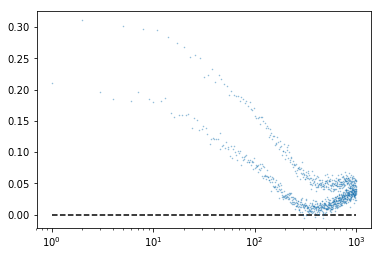

In [29]:
plt.semilogx(hilo_cov[1:] / (f_lo*f_hi), '.', alpha=0.5, ms=1)
plt.hlines(0, 1, k_max, linestyle='dashed')

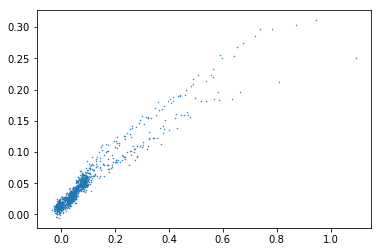

In [30]:
plt.plot(pi_cov[1:]/pi_mean**2, hilo_cov[1:]/(f_hi*f_lo), '.', ms=1)

# 4D sites

In [50]:
fourd_sites = pd.read_table('../data/dmel-4Dsites.txt', header=None, names=['Chr', 'Pos'])

In [51]:
fourd_sites.head()

,Chr,Pos
0,YHet,316
1,YHet,340
2,YHet,352
3,YHet,364
4,YHet,373


In [52]:
#Convert from one-index to zero-index
chr2L_4d = list(fourd_sites.Pos[fourd_sites.Chr == '2L'] - 1)

In [53]:
chr2L_4d[:10]

[7684, 7690, 7699, 7708, 7714, 7720, 7732, 7735, 7738, 7744]

In [54]:
data4d = np.zeros_like(data)
data4d[chr2L_4d] = data[chr2L_4d]

In [55]:
print(data4d[7685:7701])

[[ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [97  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [97  0]
 [ 0  0]]


In [56]:
nobs4d = data4d[start:stop,0]
mac4d = data4d[start:stop,1]

In [58]:
print(np.sum(nobs > 0))
print(np.sum(nobs4d>0))
print(np.sum(nobs4d>0)/np.sum(nobs>0))

13599034
433427
0.031871896195


In [59]:
pi4d = h.pairwise_diversity(mac4d, nobs4d)
pi4d[np.isnan(pi4d)] = 0
poly4d = (mac4d > 0).astype(int)
has_cov4d = (nobs4d > 0).astype(int)

/home/dpr/mmc_genomics/src/helpers.py:6: RuntimeWarning: invalid value encountered in true_divide
  f = allele_counts / sample_size
/home/dpr/mmc_genomics/src/helpers.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))
/home/dpr/mmc_genomics/src/helpers.py:7: RuntimeWarning: invalid value encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))


In [60]:
print(np.sum(pi) / np.sum(has_cov))
print(np.sum(pi4d) / np.sum(has_cov4d))

NameError: name 'pi' is not defined

In [61]:
print(np.sum(has_cov4d))

433427


In [62]:
print(np.sum(poly)/np.sum(has_cov))
print(np.sum(poly4d)/np.sum(has_cov4d))

NameError: name 'has_cov' is not defined

(array([ 2042.,  6125.,  1548.,  1856.,  1029.,  1139.,  1489.,  3389.,
         1851.,  3053.,  2541.,  2864.,  4617.,  3596.,  2050.,  1831.,
         1707.,  3378.,  4444.,  4275.,  6214.,  2292.,  1198.,  3944.,
         3780.,  3149.,  1971.,  4629.,  2804.,  1036.,   798.,  1746.,
         3048.,  3791.,  7367.,  8623.,  2238.,   966.,  3790.,  7017.,
         5606.,  9572.,  3254.,  3422.,   641.,  4639.,  1171.,  2559.,
         1614.,  5876.,  5923.,  2632.,  1098.,  4806.,  5220.,  1844.,
         5599.,  4625.,  2581.,  7413.,  3645.,  1197.,  2107.,  1902.,
         4000.,   551.,  3248.,  5257.,  4221.,   884.,  6557.,  6180.,
         3986.,  6546.,  5425.,  2090.,  2132.,  2564.,  1025.,  4164.,
         1259.,   767.,  1479.,  1717.,  1993.,  3898.,  2852.,  3657.,
         1387.,  6126.,  3391.,  2580.,  6912.,  7374.,  6615.,  1988.,
         3864.,  3626.,  3047.,  3119.,  3699.,  5527.,  2923.,   681.,
         1100.,  2849.,  1459.,  1206.,  2163.,  2636.,  5557., 

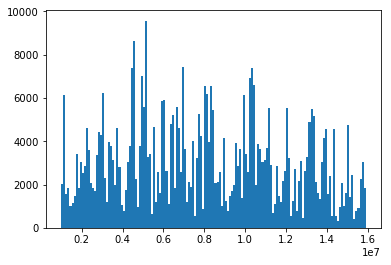

In [43]:
plt.hist(chr2L_4d, bins=np.arange(start,stop+1e6,1e5))

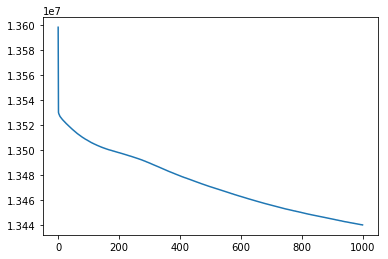

In [44]:
plt.plot(np.correlate(has_cov, has_cov[:-k_max]))

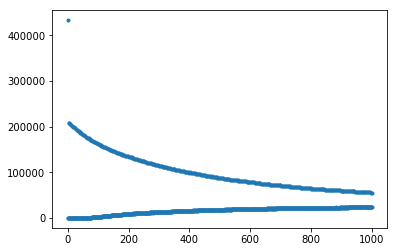

In [45]:
plt.plot(np.correlate(has_cov4d, has_cov4d[:-k_max]), '.')

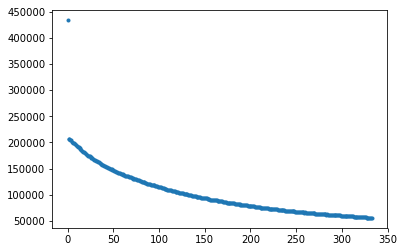

In [46]:
plt.plot(np.correlate(has_cov4d, has_cov4d[:-k_max])[::3], '.')

In [47]:
sites_4d = np.zeros(len(data))
sites_4d[chr2L_4d] = 1
sites_4d_trim = sites_4d[start:stop]

In [48]:
np.mean(sites_4d_trim)

0.031327142857142859

In [49]:
corr4d = np.correlate(sites_4d_trim, sites_4d_trim[:-10000])/(len(sites_4d_trim)-10000) - np.mean(sites_4d_trim)**2

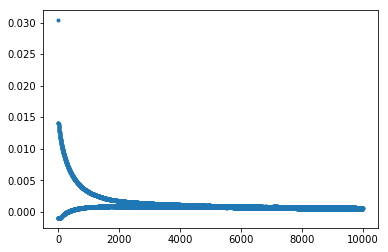

In [50]:
plt.plot(corr4d, '.')

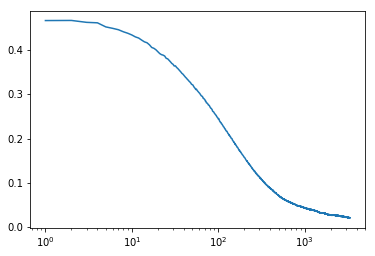

In [51]:
plt.semilogx(np.arange(3,10000,3)/3, corr4d[3::3]/corr4d[0])

In [52]:
maf4d = mac4d / nobs4d
maf4d[np.isnan(maf4d)] = 0

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [53]:
pi4d = h.pairwise_diversity(mac4d, nobs4d)
pi4d[np.isnan(pi4d)] = 0

/home/dpr/mmc_genomics/src/helpers.py:6: RuntimeWarning: invalid value encountered in true_divide
  f = allele_counts / sample_size
/home/dpr/mmc_genomics/src/helpers.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))
/home/dpr/mmc_genomics/src/helpers.py:7: RuntimeWarning: invalid value encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))


In [54]:
poly4d = (mac4d > 0).astype(int)

We need to deal with the no counts. That means adjusting the denominator by the number of comparisons with no counts.

In [55]:
has_cov4d = (nobs4d > 0).astype(int)

In [56]:
print(np.sum(poly4d)/np.sum(has_cov4d))

0.153945185694


In [57]:
comparisons4d = np.correlate(has_cov4d, has_cov4d[:-k_max])

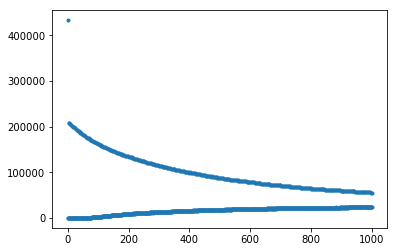

In [58]:
plt.plot(comparisons4d, '.')

In [59]:
pi_corr4d = np.correlate(pi4d, pi4d[:-k_max])

In [60]:
pi_mean4d = np.sum(pi4d) / np.sum(has_cov4d)
print(pi_mean4d)

0.023286672579


In [61]:
pi_cov4d = pi_corr4d/comparisons4d - pi_mean4d**2

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


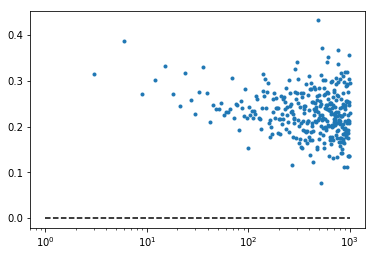

In [62]:
plt.semilogx(np.arange(3,k_max,3), pi_cov4d[3::3] / pi_mean4d**2, '.')
plt.hlines(0, 1, k_max, linestyle='dashed')

In [63]:
poly_corr4d =  np.correlate(poly4d, poly4d[:-k_max])
poly_mean4d = np.sum(poly4d) / np.sum(has_cov4d)
poly_cov4d = poly_corr4d/comparisons4d - poly_mean4d**2

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
print(poly_mean4d)
print(pi_mean4d)

0.153945185694
0.023286672579


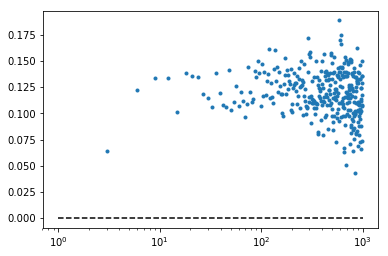

In [65]:
plt.semilogx(np.arange(3,k_max,3), poly_cov4d[3::3] / poly_mean4d**2, '.')
plt.hlines(0, 1, k_max, linestyle='dashed')

In [66]:
freq_cutoff = 0.05
hi_freq4d = ((mac4d>0) & (maf4d > freq_cutoff)).astype(int)
lo_freq4d = ((mac4d>0) & (maf4d <= freq_cutoff)).astype(int)

In [67]:
f_hi4d = np.sum(hi_freq4d) / np.sum(has_cov4d)
f_lo4d = np.sum(lo_freq4d) / np.sum(has_cov4d)
print(f_lo4d, f_hi4d, poly_mean4d)

0.0884139659043 0.0655312197902 0.153945185694


In [68]:
hilo_corr4d = np.correlate(hi_freq4d, lo_freq4d[:-k_max])

In [69]:
hilo_cov4d = hilo_corr4d/comparisons4d - f_lo4d*f_hi4d

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


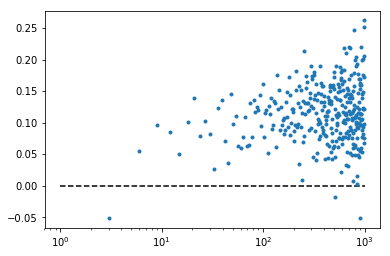

In [70]:
plt.semilogx(np.arange(3,k_max,3), hilo_cov4d[3::3]/(f_lo4d*f_hi4d), '.')
plt.hlines(0, 1, k_max, linestyle='dashed')

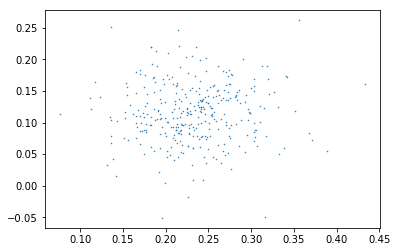

In [75]:
plt.plot(pi_cov4d[3::3]/pi_mean4d**2, hilo_cov4d[3::3]/(f_hi4d*f_lo4d), '.', ms=1)

/home/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


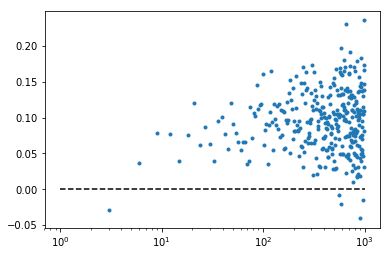

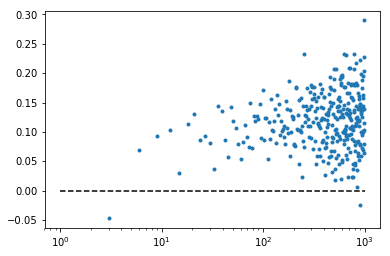

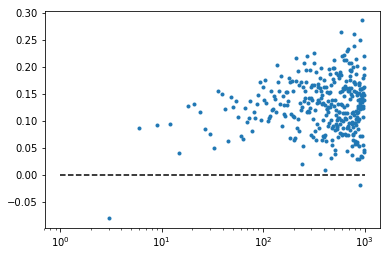

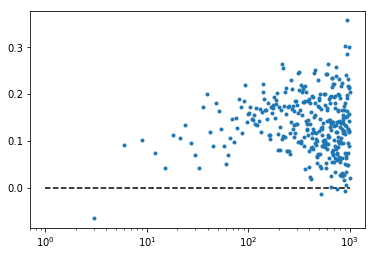

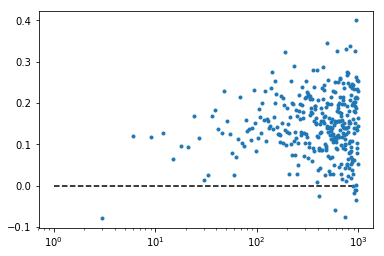

In [84]:
for cutoff in [0.03, 0.06, 0.10, 0.20, 0.30]:
    hi_freq4d = ((mac4d>0) & (maf4d > cutoff)).astype(int)
    lo_freq4d = ((mac4d>0) & (maf4d <= cutoff)).astype(int)
    
    f_hi4d = np.sum(hi_freq4d) / np.sum(has_cov4d)
    f_lo4d = np.sum(lo_freq4d) / np.sum(has_cov4d)
    
    hilo_corr4d = np.correlate(hi_freq4d, lo_freq4d[:-k_max])
    hilo_cov4d = hilo_corr4d/comparisons4d - f_lo4d*f_hi4d
    
    plt.semilogx(np.arange(3,k_max,3), hilo_cov4d[3::3]/(f_lo4d*f_hi4d), '.')
    plt.hlines(0, 1, k_max, linestyle='dashed')
    plt.show()

# Smoothing

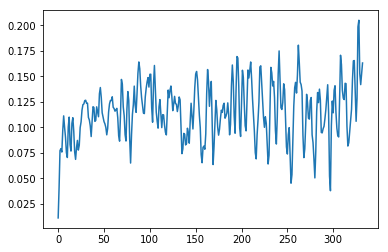

In [82]:
plt.plot(h.smooth(hilo_cov4d[3::3]/(f_hi4d*f_lo4d), window_len=5))

# GFF file

In [212]:
gff = pd.read_table('../data/dmel-cds.gff', header=None, names=['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
gff.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,2L,FlyBase,CDS,7680,8116,.,+,0,"Name=CG11023-cds;Parent=FBtr0300689,FBtr030069..."
1,2L,FlyBase,CDS,7680,8116,.,+,0,Name=CG11023-cds;Parent=FBtr0330654;parent_typ...
2,2L,FlyBase,CDS,8193,8610,.,+,1,Name=CG11023-cds;Parent=FBtr0300689;parent_typ...
3,2L,FlyBase,CDS,8193,8589,.,+,1,Name=CG11023-cds;Parent=FBtr0300690;parent_typ...
4,2L,FlyBase,CDS,8229,8610,.,+,1,Name=CG11023-cds;Parent=FBtr0330654;parent_typ...


In [ ]:
in_cds = np.zeros(len(data))
for i in range(len(data)):
    